# A Visual Guide to Using BERT for the First Time
https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

config = RobertaConfig.from_pretrained(PreTrained_Model)

config.output_hidden_states = False

model = TFRobertaModel.from_pretrained(PreTrained_Model, from_pt=True, config = config)

embedding_layer = model.roberta(tokens,attention_mask=masks,token_type_ids=segs)[0]

Features = embedding_layer[:,0,:].numpy()





In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install huggingface_hub

In [ ]:
import pandas as pd
import numpy as np

# # PRE-PROCESSING
# import string
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import spacy

# TRAIN/TEST SET
from sklearn.model_selection import StratifiedKFold, train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# nlp = spacy.load("el_core_news_sm")

In [ ]:
# testing  = pd.read_csv('TWEETS_nolinks.csv')
testing  = pd.read_csv('CHATGPT TWEETS_nolinks.csv')

# Replace empty strings with NaN
testing['class'] = testing['class'].replace(' ', np.nan)
final = testing[testing['class'].notnull()]
final = final.reset_index()
final = final[['Tweet', 'class']]
# Use astype to convert to float
final['class'] = final['class'].astype(float)
# final.head()

In [ ]:
len(final[final['class']==0])

287

In [ ]:
len(final[final['class']==1])

269

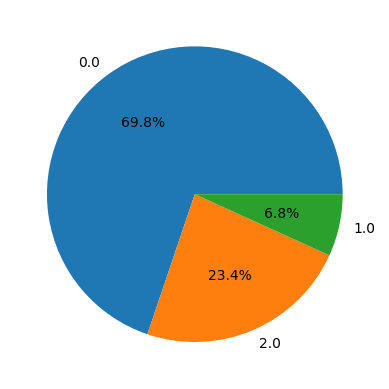

In [ ]:
import matplotlib.pyplot as plt

plt.pie(final['Label'].value_counts().values,
        labels = final['Label'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Loading the Pre-trained BERT model

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1"  )

Model #1: Preparing the Dataset

## Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

https://www.kaggle.com/code/aishwarya2210/prediction-of-tweets-using-bert-model

no need to preprocess the text with this tokenizer!

In [ ]:
tokenized = final['Tweet'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized

0      [101, 239, 9321, 349, 2067, 108, 108, 425, 356...
1      [101, 940, 9572, 394, 350, 1856, 351, 362, 426...
2      [101, 368, 239, 596, 8422, 3544, 345, 18213, 1...
3      [101, 1563, 279, 5418, 269, 8660, 279, 8996, 6...
4      [101, 2398, 713, 362, 1711, 360, 3068, 2684, 5...
                             ...                        
551    [101, 386, 1697, 354, 407, 9744, 380, 29103, 9...
552    [101, 366, 377, 374, 1181, 353, 348, 362, 2408...
553    [101, 381, 242, 433, 2398, 348, 15922, 2355, 1...
554    [101, 631, 239, 110, 1944, 357, 369, 28221, 26...
555    [101, 410, 571, 391, 742, 351, 345, 5289, 278,...
Name: Tweet, Length: 556, dtype: object

## Padding
After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
# Our dataset is now in the padded variable, we can view its dimensions below:

np.array(padded).shape

(556, 91)

In [ ]:
padded

array([[ 101,  239, 9321, ...,    0,    0,    0],
       [ 101,  940, 9572, ...,    0,    0,    0],
       [ 101,  368,  239, ...,    0,    0,    0],
       ...,
       [ 101,  381,  242, ...,    0,    0,    0],
       [ 101,  631,  239, ...,    0,    0,    0],
       [ 101,  410,  571, ...,    0,    0,    0]])

## Masking
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
attention_mask = np.where(padded != 0, 1, 0) #opou den einai 0 vale 1 alliws 0
attention_mask.shape

(556, 91)

In [ ]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
# from tensorflow.keras.layers import Input

In [ ]:
# import tensorflow as tf

In [ ]:
# input_ids = Input(shape=(max_len,), dtype=tf.int32, name="padded")
# input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = model(input_ids, attention_mask = input_mask)[0]


# embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# # out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# out = tf.keras.layers.Dropout(0.1)(embeddings)

In [ ]:
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
padded[0]

array([  101,   723,   629,   368,  1106,   433,   351,   600,   374,
         239,  3055,   479,   114,   367, 32515,   346,  9269,   267,
         344,   349, 29002,   415,  1553,   371, 22326,   265,   108,
         361,  3223,   359,  4285,   348, 20290,   278,   364,   422,
        1232, 21353,   407, 30145,   411,   148,   100,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [ ]:
features = np.ndarray([1,768]) #arxikopoihsh alliws??? fix thisssssssssssss!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#megethos = [ 1, hidden layers] gia na prosthesw apo edw k meta

for tweets in padded:
  outputs = model(torch.tensor([tweets]))[0]
  features = np.vstack([features, outputs[:,0,:].detach().numpy()])


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [ ]:
features = features[1:] #ayta einai ta embeddings

#Train/Test Split

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold.split(features, final['class'])):
        X_train, X_test, Y_train, Y_test = features[train_index], features[test_index], final['class'][train_index], final['class'][test_index]

same precedure as a normal embedding

## SVM

In [ ]:



# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale'],
              'kernel': ['rbf', 'linear']}

# grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
grid = RandomizedSearchCV(svm.SVC(class_weight='balanced'),  param_grid, cv=3, random_state=42, refit = True, verbose = 2)

# fitting the model for grid search
grid.fit(X_train, Y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(Y_test, grid_predictions))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   0.0s
[CV] END .................C=100, gamma=0.0001, k

## Random Forest

In [ ]:
# defining parameter range

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': ['gini', 'entropy'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(random_state =0, class_weight='balanced')

grid = RandomizedSearchCV(RandomForest, random_grid, cv=3, random_state=42, refit = True, verbose = 2)
# fitting the model for grid search
grid.fit(X_train, Y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(Y_test, grid_predictions))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, criterion=gini, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, criterion=gini, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, criterion=gini, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, criterion=entropy, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=222; total time=   2.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=222; total time=   1.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=222; total time=   1.8s
[CV] END bootstrap=False, criterion=gini, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=222; tota

## SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

SGDC = SGDClassifier(class_weight='balanced')

# Create the random grid
random_grid = { "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
                "alpha" : [0.0001, 0.001, 0.01, 0.1],
                "penalty" : ["l2", "l1", "elasticnet", "none"]}

grid = RandomizedSearchCV(SGDC, random_grid, cv=3, random_state=42, refit = True, verbose = 2)


# fitting the model for grid search
grid.fit(X_train, Y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(Y_test, grid_predictions))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END alpha=0.001, loss=squared_hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.001, loss=squared_hinge, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.001, loss=squared_hinge, penalty=elasticnet; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ........alpha=0.001, loss=hinge, penalty=elasticnet; total time=   0.1s
[CV] END ........alpha=0.001, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END ........alpha=0.001, loss=hinge, penalty=elasticnet; total time=   0.0s
[CV] END ......alpha=0.001, loss=squared_hinge, penalty=none; total time=   0.0s
[CV] END ......alpha=0.001, loss=squared_hinge, penalty=none; total time=   0.0s
[CV] END ......alpha=0.001, loss=squared_hinge, 

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=Y_train
)

xgb = XGBClassifier()

# Create the random grid
random_grid = { "learning_rate" : [0.05,0.1,0.15,0.20],
                 "n_estimators" : [100, 500, 900, 1100, 1500],
                 "max_depth" : [ 3, 5, 6, 10, 15],
                 "min_child_weight" : [ 1, 3, 5, 7 ],
                 "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}

grid = RandomizedSearchCV(xgb, random_grid, cv=3, random_state=42, refit = True, verbose = 2)

# fitting the model for grid search
grid.fit(X_train, Y_train, sample_weight=sample_weights)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(Y_test, grid_predictions))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=500; total time=   2.1s
[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=500; total time=   2.3s
[CV] END gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=500; total time=   2.2s
[CV] END gamma=0.3, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=1500; total time=   3.6s
[CV] END gamma=0.3, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=1500; total time=   4.7s
[CV] END gamma=0.3, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=1500; total time=   3.5s
[CV] END gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100; total time=   7.1s
[CV] END gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=100; total time=   7.9s
[CV] END gamma=0.2, learning_rate=0.05, max_depth=10, min

https://huggingface.co/docs/transformers/model_doc/roberta

In [ ]:
# from transformers import RobertaConfig, RobertaModel, TFRobertaModel

In [ ]:
# config = RobertaConfig.from_pretrained(model)

# config.output_hidden_states = False

# model = TFRobertaModel.from_pretrained(model, from_pt=True, config = config)

# embedding_layer = model.roberta(input_ids,attention_mask=attention_mask,token_type_ids=segs)[0]

# Features = embedding_layer[:,0,:].numpy()

In [ ]:
# config = RobertaConfig.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

# config.output_hidden_states = False

In [ ]:
# model = TFRobertaModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", from_pt=True, config = config)

# embedding_layer = model.roberta(padded,attention_mask=list(attention_mask) )[0]

# Features = embedding_layer[:,0,:].numpy()